In [10]:
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt

In [11]:
# category selector
cat_selector = make_column_selector(dtype_include=object)
# numeric selector
num_selector = make_column_selector(dtype_include=np.number)

# category encoder
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1)

# imputer
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

# tree based model precessor
tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector))


def make_rf_pipeline(
        n_estimators: int = 800, random_state: int = 42) -> Pipeline:
    """make random forest pipeline

    Args:
        n_estimators (int, optional): number of estimators. Defaults to 800.
        random_state (int, optional):  Defaults to 42.

    Returns:
        Pipeline: Sklearn pipeline
    """
    return make_pipeline(
        tree_preprocessor,
        RandomForestRegressor(
            random_state=random_state, n_estimators=n_estimators))

def plot_feat_importance(importances, index):
    """plot random forest importance

    Args:
        importances (_type_): feat importance 
        index (_type_): feat name
    """
    forest_importances = pd.Series(
        importances, index=index).sort_values(ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [20]:
data = pd.read_csv('../data/curated/feature_data.csv')

/var/folders/t7/dnx7ygys43vfq00ddy255g680000gn/T/ipykernel_74257/3808847927.py:1: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/curated/feature_data.csv')


In [18]:
data

,Unnamed: 0.1,Unnamed: 0,Postcode,Property Address,Bedrooms,Baths,Parking,property_type,Property Features,Weekly Rental Price,...,Bus Duration,Shopping_Center_Name,Shop Distance,Shop Duration,Count_Station,Count_Hospital,Count_School,Count_Shopping_Center,Population,Income Per Person
0,0,0,3000,CP2008/11 Rose Lane Melbourne VIC 3000,0,0,1,Carspace,[],60.0,...,2.0,COLLINS234 BOUTIQUE PLACE,1.0,6.0,45.0,4.0,4.0,18.0,34652.148872,11826.0
1,1,1,3000,CP2008/11 Rose Lane Melbourne VIC 3000,0,0,1,Carspace,[],60.0,...,2.0,COLLINS234 BOUTIQUE PLACE,1.0,6.0,45.0,4.0,4.0,18.0,34652.148872,11826.0
2,2,2,3000,CP2008/11 Rose Lane Melbourne VIC 3000,0,0,1,Carspace,[],60.0,...,2.0,COLLINS234 BOUTIQUE PLACE,1.0,6.0,45.0,4.0,4.0,18.0,34652.148872,11826.0
3,3,3,3000,CP2008/11 Rose Lane Melbourne VIC 3000,0,0,1,Carspace,[],60.0,...,2.0,COLLINS234 BOUTIQUE PLACE,1.0,6.0,45.0,4.0,4.0,18.0,34652.148872,11826.0
4,4,4,3000,CP2008/11 Rose Lane Melbourne VIC 3000,0,0,1,Carspace,[],60.0,...,2.0,COLLINS234 BOUTIQUE PLACE,1.0,6.0,45.0,4.0,4.0,18.0,34652.148872,11826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42824,42824,42824,3996,14 Inverloch Parade Inverloch VIC 3996,2,1,0,House,"['Internal Laundry*', 'Heating*', 'Garden', 'S...",420.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,36889.657143,8846.0
42825,42825,42825,3996,10 Hopetoun Street Inverloch VIC 3996,2,1,1,House,"['Heating*', 'Balcony / Deck*']",370.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,36889.657143,8846.0
42826,42826,42826,3996,10 Hopetoun Street Inverloch VIC 3996,2,1,1,House,"['Heating*', 'Balcony / Deck*']",370.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,36889.657143,8846.0
42827,42827,42827,3996,Inverloch VIC 3996,3,2,1,House,"['Heating*', 'Ensuite', 'Garden', 'Split Syste...",475.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,36889.657143,8846.0


In [21]:
#data = pd.read_csv('../data/curated/feature_data.csv')
data['Crime Rate'] = data['Crime Count']/data['Population']
data.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'Property Address', 'Health Instituion', 'Bus Station',
                    'Shopping_Center_Name', 'School Name', 'Bus Duration', 'School Duration',
                    'Health Duration', 'Shop Duration', 'Postcode', 'Crime Count', 
                   ], inplace=True)

def transform_property_type(x):
    out = x
    if x not in ('House', 'Apartment / Unit / Flat', 'Townhouse', 'Studio', 'Villa'):
        out = 'Others'
    return out

data['property_type'] = data.property_type.apply(transform_property_type)
data['heating_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Heating' in xx]) > 0 ))
data['garden_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Garden' in xx]) > 0 ))
data['parking_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Parking' in xx]) > 0 ))
data['balcony_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Balcony' in xx]) > 0 ))
data['laundry_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Laundry' in xx]) > 0 ))

data.fillna(-1, inplace=True)


In [22]:
X = data.drop(columns='Weekly Rental Price')
y = data['Weekly Rental Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [23]:
rf_pipeline = make_rf_pipeline(random_state=42, n_estimators=500)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f93fa500c70>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f93fa500c40>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=500, random_state=42))])

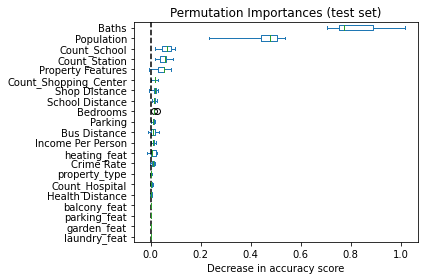

In [24]:
result = permutation_importance(
    rf_pipeline, X_test, y_test, n_repeats=15, random_state=42, n_jobs=4
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

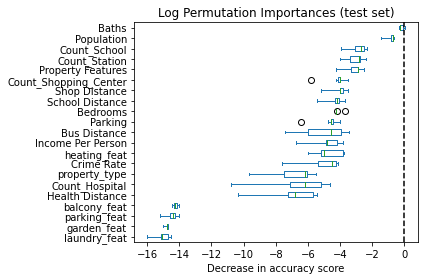

In [25]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.apply(np.log).plot.box(vert=False, whis=10)
ax.set_title("Log Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()